In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cPickle as pickle
import scipy.io
import time
import ssn
import ks_test3
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

Elapsed time to load maps: 0 seconds


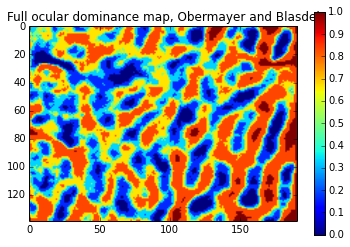

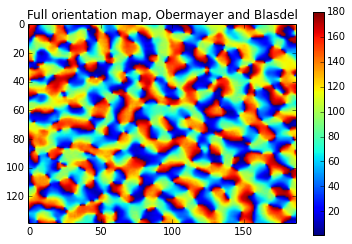

In [2]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
# [OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-7.p', 'rb')
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-13.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)

plt.figure()
plt.imshow(OD_map_full)
plt.colorbar()
plt.title('Full ocular dominance map, Obermayer and Blasdel')

plt.figure()
plt.imshow(OP_map_full)
plt.colorbar()
plt.title('Full orientation map, Obermayer and Blasdel')

OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

In [3]:
n_units = 15
selected_units = np.floor( 75*np.random.rand(n_units, 2) )

OD_prefs = np.zeros(len(selected_units))
for i in range(len(selected_units)):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    OD_prefs[i] = OD_map[yi,xi]

In [4]:
# Generate SSN with specified hyperparams:
ss_net = ssn.SSNetwork(ori_map=OP_map, ocd_map=OD_map)

c = 40
dt = 0.005
timesteps = 100
dx = ss_net.dx
N_pairs = ss_net.N_pairs

In [5]:
# generate monocular stimuli for size tuning:
stim_sizes = np.linspace(1,10,15)
dom_stimuli = np.zeros((n_units, len(stim_sizes), N_pairs, N_pairs))

for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    ocularity = np.round(OD_prefs[i])
    for j in range(len(stim_sizes)):
        dom_stimuli[i,j,:,:] = ssn.generate_ext_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map, OD_map, ocularity)

In [6]:
# probe the monocular size tuning for the selected units:
dom_size_tuning_results = np.zeros((n_units, len(stim_sizes), 2))

st = time.time()
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    for j in range(len(stim_sizes)):
        h = dom_stimuli[i,j,:,:]
        [r_E, r_I, I_E, I_I] = ss_net.run_simulation(dt, timesteps, c, h )
        dom_size_tuning_results[i,j,0] = r_E[-1,yi,xi]
        dom_size_tuning_results[i,j,1] = r_I[-1,yi,xi]        
        
print "Elapsed time: %d seconds" %(time.time()-st)

Elapsed time: 7512 seconds


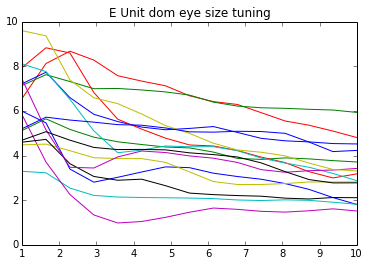

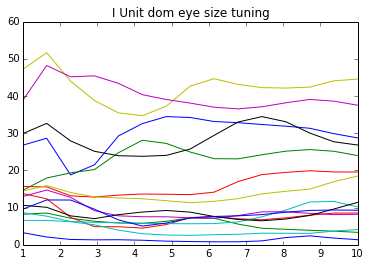

In [7]:
plt.figure()
plt.title('E Unit dom eye size tuning')
for i in range(n_units):
    plt.plot(stim_sizes, dom_size_tuning_results[i,:,0])
    
plt.figure()
plt.title('I Unit dom eye size tuning')
for i in range(n_units):
    plt.plot(stim_sizes, dom_size_tuning_results[i,:,1])    

In [10]:
# find the SFS for each unit:
dom_sfs_E = np.zeros(n_units)
dom_sfs_I = np.copy(dom_sfs_E)
sfs_fr_E = np.zeros(n_units)
sfs_fr_I = np.copy(sfs_fr_E)

for i in range(n_units):
    for j in range(len(stim_sizes)):
        if dom_size_tuning_results[i,j,0] > sfs_fr_E[i]:
            sfs_fr_E[i] = dom_size_tuning_results[i,j,0]
            dom_sfs_E[i] = stim_sizes[j]
        else:
            break
            
for i in range(n_units):
    for j in range(len(stim_sizes)):
        if dom_size_tuning_results[i,j,1] > sfs_fr_I[i]:
            sfs_fr_I[i] = dom_size_tuning_results[i,j,1]
            dom_sfs_I[i] = stim_sizes[j]
        else:
            break

In [31]:
# Now probe the non dominant stimuli:
nd_surr_stimuli = np.zeros((n_units, len(stim_sizes), 2, N_pairs, N_pairs))
surr_stim_sizes = np.zeros((n_units, len(stim_sizes), 2) )
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    ori = OP_map[yi,xi]
    dom_ocu = np.round(OD_prefs[i])
    centre = ssn.generate_ext_stimulus( ori, dom_sfs_E[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
    surr_stim_sizes[i,:,0] = np.linspace(dom_sfs_E[i],np.max(stim_sizes),len(stim_sizes))
    nd_ocu = np.abs(dom_ocu-1)
    nd_surr_stimuli[i,0,0,:,:] = centre
    
    for j in range(1,len(stim_sizes)):
        surround = ssn.generate_ring_stimulus( ori, dom_sfs_E[i], surr_stim_sizes[i,j,0], [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
        nd_surr_stimuli[i,j,0,:,:] = centre + surround
        
    centre = ssn.generate_ext_stimulus( ori, dom_sfs_I[i], [dx*xi, dx*yi], OP_map, OD_map, dom_ocu )
    nd_surr_stimuli[i,0,1,:,:] = centre
    surr_stim_sizes[i,:,1] = np.linspace(dom_sfs_I[i],np.max(stim_sizes),len(stim_sizes))
    for j in range(1,len(stim_sizes)):
        surround = ssn.generate_ring_stimulus( ori, dom_sfs_I[i], surr_stim_sizes[i,j,1], [dx*xi, dx*yi], nd_ocu, OP_map, OD_map)
        nd_surr_stimuli[i,j,1,:,:] = centre + surround

In [32]:
non_dom_size_tuning_results = np.zeros((n_units, len(stim_sizes), 2))

st = time.time()
for i in range(n_units):
    xi = selected_units[i,0]
    yi = selected_units[i,1]
    for j in range(len(stim_sizes)):
        h = nd_surr_stimuli[i,j,0,:,:]
        [r_E, r_I, I_E, I_I] = ss_net.run_simulation(dt, timesteps, c, h )
        non_dom_size_tuning_results[i,j,0] = r_E[-1,yi,xi]
        
        if surr_stim_sizes[i,j,0] == surr_stim_sizes[i,j,1]:
            non_dom_size_tuning_results[i,j,1] = r_I[-1,yi,xi]    
        else:
            h = nd_surr_stimuli[i,j,1,:,:]
            [r_E, r_I, I_E, I_I] = ss_net.run_simulation(dt, timesteps, c, h )
            non_dom_size_tuning_results[i,j,1] = r_I[-1,yi,xi]    
        
print "Elapsed time: %d seconds" %(time.time()-st)

Elapsed time: 11689 seconds


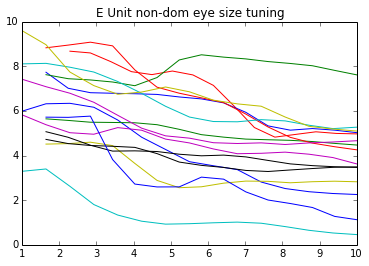

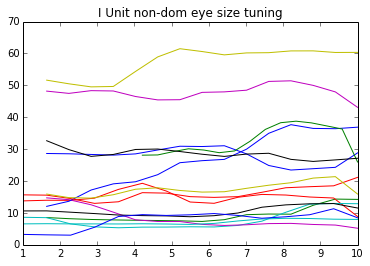

In [33]:
plt.figure()
plt.title('E Unit non-dom eye size tuning')
for i in range(n_units):
    plt.plot(surr_stim_sizes[i,:,0], non_dom_size_tuning_results[i,:,0])
    
plt.figure()
plt.title('I Unit non-dom eye size tuning')
for i in range(n_units):
    plt.plot(surr_stim_sizes[i,:,1], non_dom_size_tuning_results[i,:,1])

In [ ]:
print dom_sfs_E

1.0
1.64285714286


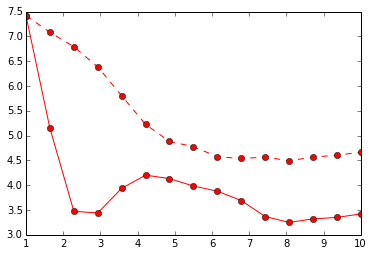

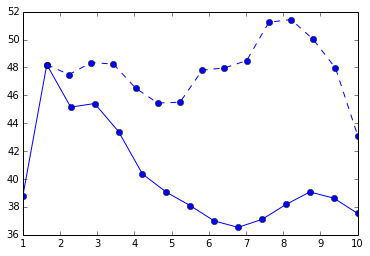

In [34]:
i = 11
plt.figure()
plt.plot(stim_sizes, dom_size_tuning_results[i,:,0],'ro-')
plt.plot(surr_stim_sizes[i,:,0], non_dom_size_tuning_results[i,:,0],'ro--')
print dom_sfs_E[i]

plt.figure()
plt.plot(stim_sizes, dom_size_tuning_results[i,:,1],'bo-')
plt.plot(surr_stim_sizes[i,:,1], non_dom_size_tuning_results[i,:,1],'bo--')
print dom_sfs_I[i]

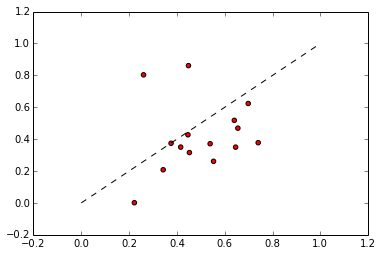

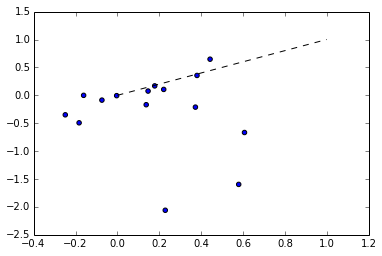

In [36]:
dom_SI_E = (sfs_fr_E - dom_size_tuning_results[:,-1,0])/sfs_fr_E
non_dom_SI_E = (sfs_fr_E - non_dom_size_tuning_results[:,-1,0])/sfs_fr_E

plt.figure()
plt.scatter(dom_SI_E, non_dom_SI_E, c='r')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Dominant SI \%")
plt.ylabel("Non-dominant SI \%")
plt.title("Interocular Suppression - E units")

dom_SI_I = (sfs_fr_I - dom_size_tuning_results[:,-1,1])/sfs_fr_I
non_dom_SI_I = (sfs_fr_I - non_dom_size_tuning_results[:,-1,1])/sfs_fr_I
                    
plt.figure()
plt.scatter(dom_SI_I, non_dom_SI_I, c='b')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Dominant SI \%")
plt.ylabel("Non-dominant SI \%")
plt.title("Interocular Suppression - I units")

Running a 2D, 2 sample Kolmogorov-Smirnov test!
K-S test p-value, E units:  0.0461275220445
Running a 2D, 2 sample Kolmogorov-Smirnov test!
K-S test p-value, I units:  3.46062425416e-05


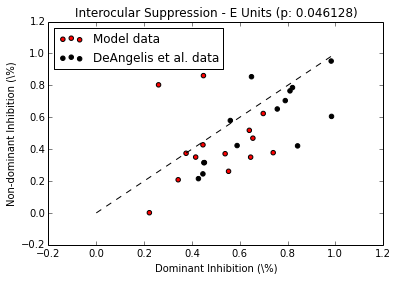

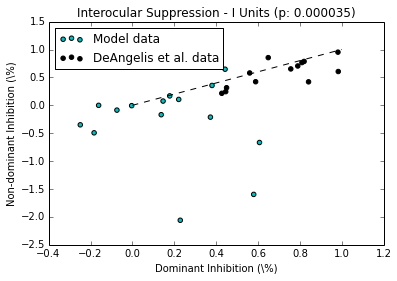

In [51]:
deangelis_data = np.array([[42.711, 21.488],
[44.588, 24.483],
[44.999, 31.508],
[58.885, 42.252],
[56.048, 57.955],
[64.901, 85.434],
[75.685, 65.186],
[79.023, 70.455],
[84.173, 42.045],
[98.365, 60.537],
[98.224, 95.248],
[82.045, 78.616],
[81.002, 76.550]])
deangelis_data = deangelis_data/100

# model_data_x = np.concatenate((dom_SI_E, dom_SI_I))
# model_data_y = np.concatenate((non_dom_SI_E, non_dom_SI_I))

d, E_prob = ks_test3.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_E, non_dom_SI_E)
print "K-S test p-value, E units: ", E_prob

plt.figure()
plt.scatter(dom_SI_E, non_dom_SI_E, c='r', label="Model data")
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label="DeAngelis et al. data")
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc='best')
plt.title("Interocular Suppression - E Units (p: %5.6f)" % E_prob )
plt.xlabel("Dominant Inhibition (\%)")
plt.ylabel("Non-dominant Inhibition (\%)")
plt.savefig('results/interocular_transfer/deangelis_fig14_E.png')

d, I_prob = ks_test3.ks2d2s(deangelis_data[:,0], deangelis_data[:,1], dom_SI_I, non_dom_SI_I)
print "K-S test p-value, I units: ", I_prob

plt.figure()
plt.scatter(dom_SI_I, non_dom_SI_I, c='c', label="Model data")
plt.scatter(deangelis_data[:,0], deangelis_data[:,1], c='k', label="DeAngelis et al. data")
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc='best')
plt.title("Interocular Suppression - I Units (p: %5.6f)" % I_prob)
plt.xlabel("Dominant Inhibition (\%)")
plt.ylabel("Non-dominant Inhibition (\%)")
plt.savefig('results/interocular_transfer/deangelis_fig14_I.png')

In [53]:
print "# of I units showing dominant eye facilitation: %d of %d" % (len(np.where(dom_SI_I<0)[0]), len(dom_SI_I))
print "# of I units showing non-dominant eye facilitation: %d of %d" % (len(np.where(non_dom_SI_I<0)[0]), len(non_dom_SI_I))

# of I units showing dominant eye facilitation: 5 of 15
# of I units showing non-dominant eye facilitation: 10 of 15
